# Decision Trees: Predicting Abalone Traits

------------  

_Authors: Jacob Koehler, Dhavide Aruliah_

<a id="questions"></a>
## Questions

+ [**Question 1: Instantiating a `DecisionTreeRegressor`**](#q-instantiating)
+ [**Question 2: Fitting the Model**](#q-fitting)
+ [**Question 3: Scoring the model**](#q-scoring)
+ [**Question 4: Interpreting Relative Importance of Features**](#q-interpreting)
+ [**Question 5: Ranking Features by Importance**](#q-ranking)
+ [**Question 6: Carrying out a Brute-Force Grid Search**](#q-searching)
+ [**Question 7: Using `GridSearchCV`**](#q-using)
+ [**Question 8: Comparing to Linear Regression**](#q-comparing)
+ [**Question 9: Using Decision Trees for Classification**](#q-classifying)
+ [**Question 10: Tuning Classification Hyperparameters**](#q-tuning)
+ [**Question 11: Getting a Classification Report**](#q-reporting)

This module deals with *decision trees*, flowchart-like data structures for solving *both* regression and classification problems (so decision trees fall under the umbrella of methods for *supervised machine learning*). Through this assignment, you will explore the use of Scikit-Learn's implementations of decision trees while experimenting with a biological data set. Of course, decision trees are useful in virtually any application context (i.e., not just in marine biology); all that is required is a dataset of observations with well-defined quantitative features (discrete or continuous) on which branching decisions can be made.

The main goals in this portion of the assignment are:

- to practice using Scikit-Learn idioms for supervised learning;
- to apply decision trees for the solution of regression & classification problems;
- to apply grid-search techniques for hyperparameter selection; and
- to become more familiar with metrics for evaluating & comparing machine learning models.

This assignment prefaces later work with ensemble methods based on decision trees.

![](./resource/asnlib/publicdata/abalone.jpg)

According to [Wikipedia](https://en.wikipedia.org/wiki/Abalone):

> *Abalone are marine snails. Their taxonomy puts them in the family Haliotidae, which contains only one genus, Haliotis, which once contained six subgenera. These subgenera have become alternate representations of Haliotis. The number of species recognized worldwide ranges between 30 and 130 with over 230 species-level taxa described. The most comprehensive treatment of the family considers 56 species valid, with 18 additional subspecies.*

The file [`abalone.data`](./resource/asnlib/publicdata/abalone.data) contains a dataset with measurements of over 4,000 different abalone. The first goal is to predict the age (number of rings) from the other features. A rief description of the dataset is availble locally in the file [`abalone.names`](./resource/asnlib/publicdata/abalone.names); these are extracted from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Abalone).


|Name|Data Type|Meas.|Description|
| ------- | --------- | --------- | -------- |
|Sex|nominal|M, F, and I (infant)|
|Length|continuous|mm|Longest shell measurement|
|Diameter|continuous|mm|perpendicular to length|
|Height|continuous|mm|with meat in shell|
|Whole weight|continuous|grams|whole abalone|
|Shucked weight|continuous|grams|weight of meat|
|Viscera weight|continuous|grams|gut weight (after bleeding)|
|Shell weight|continuous|grams|after being dried|
|Rings|integer|| add 1.5 to get age in years|


In [1]:
# Usual imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Imports from scikit-learn relevant to this assignment
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression

### Exploring & Preparing the Data

You can load the data into a Pandas DataFrame as usual using `read_csv`. You can then get a sense of it with the methods `head` and `info`.

In [2]:
FILE_PATH = './resource/asnlib/publicdata/abalone.data'
df = pd.read_csv(FILE_PATH, sep=',', header=None,
                 names=['sex', 'length', 'diameter', 'height',
                        'whole_weight', 'shucked_weight',
                        'viscera_weight', 'shell_weight', 'rings'])

In [3]:
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
sex               4177 non-null object
length            4177 non-null float64
diameter          4177 non-null float64
height            4177 non-null float64
whole_weight      4177 non-null float64
shucked_weight    4177 non-null float64
viscera_weight    4177 non-null float64
shell_weight      4177 non-null float64
rings             4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


The dataset is clean in that there are no missing values (which is atypical). The features are mostly continuous numerical quantities with the exception of `sex` (which is a nominal feature) and `rings` (the number of rings which is a positive integer). The `rings` feature is a proxy for the age of an abalone.

At first, you'll treat the quantity `rings` as the target, i.e., you'll set up a regression model to predict `rings` from the other features. You can get a sense of the distribution of `rings` with typical statistical summaries.

In [5]:
df_max_rings = df.rings.max()
df_min_rings = df.rings.min()
print('There are {} observations and {} features.'.format(*df.shape))
print('The number of rings varies between {} and {}.'.format(df_min_rings, df_max_rings))
# View more statistics
df[['rings']].describe()

There are 4177 observations and 9 features.
The number of rings varies between 1 and 29.


,rings
count,4177.000000
mean,9.933684
std,3.224169
min,1.000000
25%,8.000000
50%,9.000000
75%,11.000000
max,29.000000


The `sex` column in fact has three distinct values: `F` (female), `M` (male), & `I` (infant).

In [6]:
df.sex.value_counts()

M    1528
I    1342
F    1307
Name: sex, dtype: int64

For most regression models, you need encode the `sex` feature with *dummy variables* first. This can be achieved with the Pandas function `get_dummies` (the option `drop_first` allows the three catagories to be encoded with two dummy variables).

In [7]:
df = pd.get_dummies(df, columns = ['sex'], drop_first=True)

You can now prepare training & testing datasets (as Pandas `DataFrame` & `Series` objects) using the usual Scikit-Learn `train_test_split` function. You could use Numpy `array` objects alternatively, but the Pandas data structures have the added convenience of encoding feature names as well.

In [8]:
X = df.drop('rings', axis = 1)
y = df.rings
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 24)
print('Training examples: {}'.format(X_train.shape[0]))
print('Testing examples:  {}'.format(X_test.shape[0]))

Training examples: 3132
Testing examples:  1045


<a id="q-instantiating"></a>
[Return to top](#questions)

### Question 1: Instantiating a `DecisionTreeRegressor`

Your first task is to create an instance of the `DecisionTreeRegressor` class (*as demonstrated in Video 17-2.*).  There are over a dozen hyperparameters that can be tuned for this estimator (with the following default settings):

```python
DecisionTreeRegressor(criterion='mse', splitter='best',
                      max_depth=None, min_samples_split=2, 
                      min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                      max_features=None, random_state=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, presort=False)
```

For this problem, you will set only the `max_depth` and `random_state` arguments.

+ Instantiate the `DecisionTreeRegressor` with a `max_depth` of 4 and a `random_state` of 24.
+ Assign the resulting object to the identifier `ans_1`.
+ Recall: *in an IPython shell, you can access the documentation for the regressor by executing `DecisionTreeRegressor?`.*

In [9]:
# Uncomment for Documentation Help
#DecisionTreeRegressor?

In [10]:
### GRADED
### QUESTION 1
### Create an instance of the DecisionTreeRegressor
### using a max_depth of 4 and random_state of 24.
### Save the instance as ans_1 below.
### YOUR SOLUTION HERE:
ans_1 = DecisionTreeRegressor(max_depth=4, random_state=24)


In [11]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###
regr_tree = ans_1  # Associate answer with more convenient identifier

[Return to top](#questions)
<a id="q-fitting"></a>

### Question 2: Fitting the Model

Use the `fit` method associated with the estimator `reg_tree` from the previous question to fit the training data.
+ Remember, the training data is stored in `X_train` and `y_train`.
+ You will not have to create a new object. Remember, the `fit` method operates in place, i.e., it modifies the state of the object without having to bind the result to a new identifier.
+ Again, *this is demonstrated in video 17-2*.

In [12]:
### GRADED
### QUESTION 2
### Modify the object regr_tree DecisionTreeRegressor by fitting
###   it to the training data.
### YOUR SOLUTION HERE:
regr_tree.fit(X_train,y_train)
### Verification:
results = pd.DataFrame(index=X_train.columns, data={'importance':regr_tree.feature_importances_})
print('Feature importances:\n{}'.format(results))

Feature importances:
                importance
length            0.000000
diameter          0.000000
height            0.000000
whole_weight      0.001425
shucked_weight    0.162215
viscera_weight    0.000000
shell_weight      0.825138
sex_I             0.008299
sex_M             0.002923


In [13]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


<a id="q-scoring"></a>
[Return to top](#questions)

### Question 3: Scoring the model

You will now use the object `regr_tree` to compute the score using the test data.

+ By default, the `DecisionTreeRegressor` method `score` computes the $R^2$ score.
+ Assign the resulting value to the identifier `ans_3.
+ *This technique is demonstrated in Video 17-2*.

In [14]:
### GRADED
### QUESTION 3
### Apply the score() method with the testing data to determine
###     the R-squared score.
### Save the score computed to ans_3 below.
### YOUR SOLUTION HERE:
ans_3 = regr_tree.score(X_test,y_test)
# Verification:
print('The r2 score is {:5.3f}.'.format(ans_3))

The r2 score is 0.430.


In [15]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


The accuracy as measured by $R^2$ is not great, but you do have a very interpretable solution through diagrams.

## Visualizing Decision Trees

You can construct a diagram of a decision tree as a flowchart using utilities from the [`graph_viz`](http://www.graphviz.org) library. The following code constructs such a flowchart from the regression tree `regr_tree` produced so far.

In [16]:
# Necessary imports
from io import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

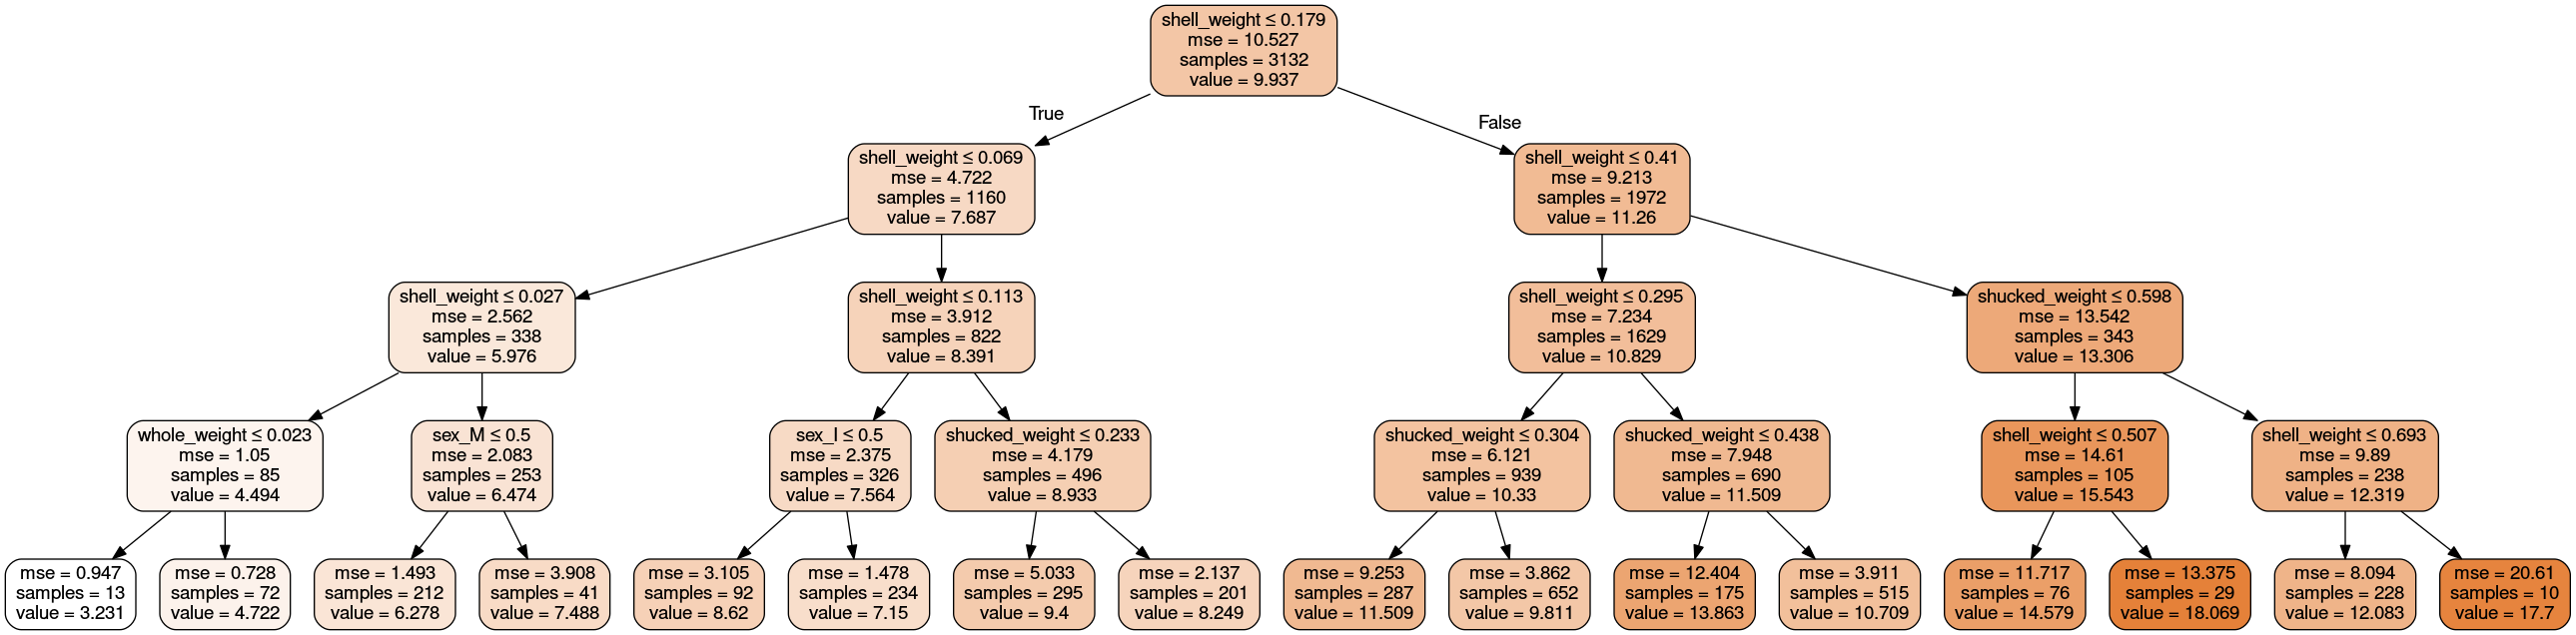

In [17]:
names = X_train.columns
dot_data = StringIO()
export_graphviz(regr_tree, out_file=dot_data,  feature_names=names, filled=True,
                rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

This is a bit hard to read due to the size of the tree produced with depth 4. You'll make other trees with varying depths. To make it easier to visualize decision tree models, you can embed the code for producing the diagram within a function.

In [18]:
def visualize_decision_tree(tree, filled=True, rounded=True,
                            special_characters=True, **kwargs):
    '''Produces Image (for display in notebook) from decision tree model
    Input:
    tree: (trained) sklearn DecisionTreeRegressor or DecisionTreeClassifier
    filled: (default True) whether to fill boxes
    rounded: (default True) whether to round corners of boxes
    special_characters: (default True) whether to permit special characters in labels
    **kwargs: other optional keyword arguments as accepted by 
              sklearn.tree.export_graphviz
    Output: returns IPython.display.Image object
    '''
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data, filled=filled,
                    rounded=rounded, special_characters=special_characters,
                    **kwargs)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

Now you can instantiate new trees with different depths and easily produce flowcharts.

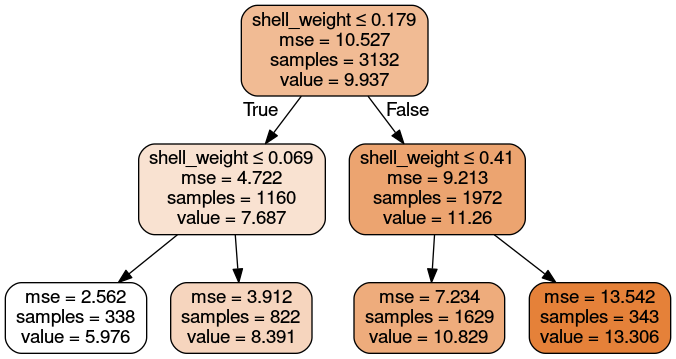

In [19]:
tree2 = DecisionTreeRegressor(max_depth = 2, random_state=24)
tree2.fit(X_train, y_train)
visualize_decision_tree(tree2, feature_names=X_train.columns)

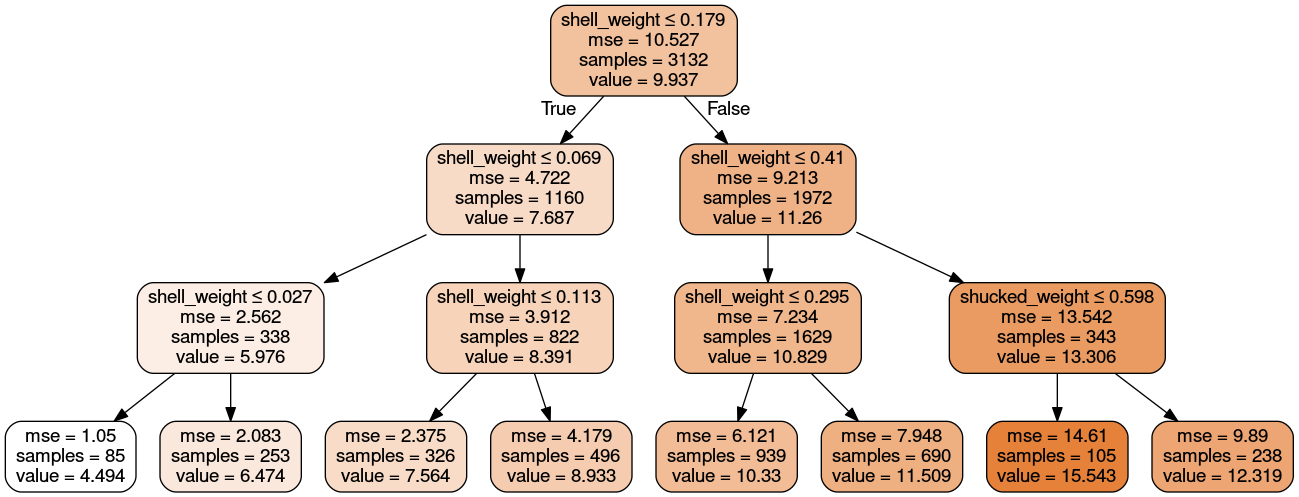

In [20]:
tree3 = DecisionTreeRegressor(max_depth = 3, random_state=24)
tree3.fit(X_train, y_train)
visualize_decision_tree(tree3, feature_names=X_train.columns)

## Interpreting Relative Importance of Features

Decision trees are useful not only due to the convenient visual representations. They can also be be used to quantitatively track the relevance of features used in splitting the tree into branches. The `DecisionTreeRegressor` attribute `feature_importances_` stores an array of nonegative numbers after training (as printed in `results` in Question 2). Both the `DecisionTreeRegressor` and `DecisionTreeClassifier` classes have the attribute `feature_importances_` to quantify each feature's importance in the decision-making process.

In [21]:
# Repeat the construction from earlier
regr_tree = DecisionTreeRegressor(max_depth=None, random_state=32)
regr_tree.fit(X_train, y_train)
results = pd.DataFrame(index=X_train.columns,
                       data={'importance':regr_tree.feature_importances_})
results

,importance
length,0.043966
diameter,0.056949
height,0.056110
whole_weight,0.087665
shucked_weight,0.171467
viscera_weight,0.066363
shell_weight,0.497183
sex_I,0.012050
sex_M,0.008248


<a id="q-interpreting"></a>
[Return to top](#questions)

### Question 4: Interpreting Relative Importance of Features

Which feature appears to be the most important for estimating the number of rings?
+ Use a Python string (chosen from the index labels of `results`) for your answer.
+ Assign your choice to `ans_4` below.

In [22]:
### GRADED
### QUESTION 4
### Which is the most important feature as determined by the trained
###     model regr_tree?
### Save your answer to ans_4 as a Python string.
### YOUR SOLUTION HERE:
ans_4 = "shell_weight"
### Verification:
print('The most important feature is {}.'.format(ans_4))

The most important feature is shell_weight.


In [23]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


<a id="q-ranking"></a>
[Return to top](#questions)

### Question 5: Ranking Features by Importance

Your task now is to rank the 4 most important features (according to the regression tree model `regr_tree` constructed above) from most important to least important.
+ You can use the object `results` again (as created just before Question 4).
+ Either of the Pandas `DataFrame` methods `sort_values` or `nlargest` can both be useful here.
+ Return the resulting object as a Pandas `Series` or `DataFrame` object with the appropriate feature names on the index and the importance scores (as determined by `regr_tree.feature_importances_`) as a column of 4 values.
+ Assign the result as `ans_5`.

In [24]:
### GRADED
### QUESTION 5
### Construct a Series of DataFrame sorted in decreasing order of importance
###    with the 4 most important feature names on the index (from regr_tree).
### Assign the result to ans_5
### YOUR SOLUTION HERE:
x = pd.DataFrame(results)
y = x.sort_values('importance', ascending=False)
ans_5 = y.iloc[:4]
### Verification:
display(ans_5)

,importance
shell_weight,0.497183
shucked_weight,0.171467
whole_weight,0.087665
viscera_weight,0.066363


In [25]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [26]:
# preserve this list for future use
most_important_features = list(ans_5.index)
print(most_important_features)

['shell_weight', 'shucked_weight', 'whole_weight', 'viscera_weight']


## Carrying out Grid Searches for Optimal Hyperparameters

Now that you are familiar with instantiating decision trees, fitting them to data, and viewing them, you can experiment with improving performance by varying hyperparameters like `max_depth`. The brute force approach to do this is to construct a loop (as in *Video 17-3*) with the depth as the loop variable. Within the loop, you would instantiate a decision tree of the appropriate depth, fit it to the training data, and then use the testing data to compute the RMSE (*root-mean square error*) and $R^2$ values for each tree.

In [27]:
rmse_values, r2_values = [], []
depths = list(range(2,20))
for depth in depths:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=24)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)
    r2_values.append(tree.score(X_test, y_test))
# Summarize results in a Pandas DataFrame for easy viewing
grid_search_results = pd.DataFrame(
                         index=pd.Index(data=depths, name='Depths'),
                         data={'RMSE':rmse_values, 'R2':r2_values})
# Display the transpose for more convenient viewing
display(grid_search_results.T)

Depths,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
RMSE,2.524839,2.469209,2.385746,2.368600,2.419289,2.420407,2.479918,2.532517,2.652368,2.685593,2.721238,2.759016,2.793346,2.851193,2.892837,2.912205,2.859889,2.874213
R2,0.361971,0.389777,0.430333,0.438491,0.414201,0.413660,0.384472,0.358084,0.295890,0.278139,0.258850,0.238129,0.219051,0.186371,0.162430,0.151177,0.181401,0.173180


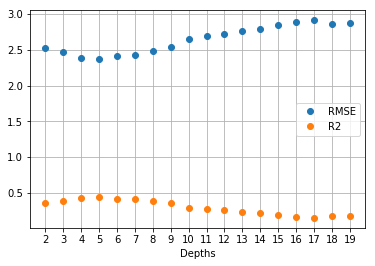

In [28]:
# Use Pandas DataFrame plot methods to view results
ax = grid_search_results.plot.line(linestyle='none', marker='o');
ax.set_xticks(ticks=depths)
plt.grid(True);

<a id="q-searching"></a>
[Return to top](#questions)

### Question 6: Carrying out a Brute-Force Grid Search

Determine the optimal depth of a `DecisionTreeRegressor` using the `DataFrame` `grid_search_results` and/or the plot above. That is, which depth is optimal (i.e., in having the lowest RMSE and the highest $R^2$ values respectively)?

+ Assign your answer (as a Python integer) to `ans_6`.

In [29]:
### GRADED
### QUESTION 6
### What is the optimal setting for max_depth?
### Save your answer to ans_6 as a Python integer.
### YOUR SOLUTION HERE:
ans_6 = 5
### Verification:
depth = ans_6
results_tuple = (depth, *grid_search_results.loc[depth, 'RMSE':'R2'])
msg = 'Optimal depth:\t{}\nOptimal RMSE:\t{:6.4f}\nOptimal R2:\t{:6.4f}'
print(msg.format(*results_tuple))

Optimal depth:	5
Optimal RMSE:	2.3686
Optimal R2:	0.4385


In [30]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


## Using `GridSearchCV`

In practice, you don't have to set up and manage a loop building lists of scores explicitly to determine optimal hyperparameters like `max_depth`. The module `sklearn.model_selection` includes a class called `GridSearchCV` for this very purpose.

When you instantiate a `GridSearchCV` class, you have the following parameters (with default options shown):

```python
GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, 
             n_jobs=None, iid='warn', refit=True, cv='warn', verbose=0, 
             pre_dispatch='2*n_jobs', error_score='raise-deprecating',
             return_train_score='warn')
```
Only two arguments are mandatory:

- **`estimator`**: an instance of the `DecisionTreeRegressor` (or a similar Scikit-Learn `Estimator` class)
- **`param_grid`**: a dictionary whose key-value pairs comprise estimator hyperparameters names as keys and iterables as values (the iterables containing putative hyperparameter values).

An estimator object needs to be instantiated but *not* fit to data to instantiate the `GridSearchCV` object. After that, the resulting object can be fit to the training data (iterating over the grid and carrying out cross-validation for each set of hyperparameter values). Notice also that the `GridSearchCV` compatible with any Scikit-Learn estimator class (i.e., not just the `DecisionTreeRegressor` class) and can determine optimal values of several hyperparameters.

For example, in the present context, you can repeat the example above of searching for an optimal depth of a regression tree. As above, the hyperparameter `max_depth` ranges from 2 to 19. In this case, the code to carry out the grid search is as follows:

In [31]:
# Instantiate the default object to clone
regr_tree = DecisionTreeRegressor(random_state=24)
# Construct the hyperparameter grid
params = {'max_depth': list(range(2, 20))}
# Instantiate the GridSearchCV object using the estimator object,
#    the hyperparameter grid, & 10-fold cross-validation
grid_regr = GridSearchCV(regr_tree, param_grid=params, cv=10)
grid_regr # displays the parameters of the GridSearch CV object

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=24,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=

<a id="q-using"></a>
[Return to top](#questions)

### Question 7: Using `GridSearchCV`

Having instantiated the `GridSearchCV` object `grid_regr`, you can now train it.
+ Apply the `fit` method of the object `grid_regr` using the training data `X_train` & `y_train`. Remember, this occurs in place.
+ Having trained the estimator `grid_regr`,  compute the $R^2$ score with the resulting estimator using the `score` method and the testing data `X_test` & `y_test`. Assign the result to `ans_7a`.
+ You can also extract the optimal hyperparameters (as a `dict`) from `grid_regr` using the attribute `best_params_`. Assign the result to `ans_7b`.
+ Finally, you can extract the optimal estimator from `grid_regr` using the attribute `best_estimator_`. Assign the result to `ans_7c`.

In [32]:
### GRADED
### QUESTION 7
### Use the fit method to train the GridSearchCV object grid_regr.
### Compute the R-squared score from the resulting trained model.
###    Assign the result to ans_7a.
### What are the optimal hyperparameters (as a dict)?
###    Assign the result to ans_7b.
### What is the optimal estimator (as a DecisionTreeRegressor object)?
###    Assign the result to ans_7c.

z = grid_regr.fit(X_train, y_train)
ans_7a = z.score(X_test, y_test)
ans_7b = grid_regr.best_params_
ans_7c = grid_regr.best_estimator_



### YOUR SOLUTION HERE:
### Verification:
print('Optimal R2 score: {:6.4f}'.format(ans_7a))
print('Optimal hyperparameter(s): {}.'.format(ans_7b))
print('Optimal Estimator:\n{}'.format(ans_7c))

Optimal R2 score: 0.4385
Optimal hyperparameter(s): {'max_depth': 5}.
Optimal Estimator:
DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=24, splitter='best')


In [33]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


## Comparing to Linear Regression

Now that you know how to build and tune a `DecisionTreeRegressor` using `GridSearchCV`, you may want to compare the tuned model `grid_regr` to another model's performance.  For example, you may want to use the most important features in a standard `LinearRegression` model. In the following, you'll use the 4 most relevant features to build your regression model (as identified in Question 5) and the datasets split as before.

In [34]:
print(most_important_features)
# Redefining training & testing data accordingly
X_train = X_train[most_important_features]
X_test = X_test[most_important_features]

['shell_weight', 'shucked_weight', 'whole_weight', 'viscera_weight']


In [35]:
# Defining a new GridSearchCV object for a hyperparameter search
#    with the new training data.
regr_tree = DecisionTreeRegressor(random_state=24)
# Construct the hyperparameter grid
params = {'max_depth': list(range(2,6))}
# Instantiate the GridSearchCV object using the estimator object,
#    the hyperparameter grid, & 5-fold cross-validation
grid_regr = GridSearchCV(regr_tree, param_grid=params, cv=5)

In [36]:
grid_regr

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=24,
                                             splitter='best'),
             iid='warn', n_jobs=None, param_grid={'max_depth': [2, 3, 4, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

<a id="q-comparing"></a>
[Return to top](#questions)

### Question 8: Comparing to Linear Regression

Your task now is to construct & train a `LinearRegression` object (using only the features from `most_important_features`) to compare it to a `DecisionTreeRegressor` trained on the same data.
+ Instantiate & assign a new `LinearRegression` object to `ans_8a`.
+ Use the features `X_train` & targets `y_train` to train the model `grid_regr`.
+ Use the features `X_train` & targets `y_train` to train the model `ans_8a`.
+ Use the trained regression model `grid_regr` & the testing data `X_test` & targets `y_test` to compute the $R^2$ statistic. Assign the result as `ans_8b`.
+ Use the trained regression model `ans_8a` & the testing data `X_test` & targets `y_test` to compute the $R^2$ statistic. Assign the result as `ans_8c`.

In [37]:
### GRADED
### Set up and fit the training data to a LinearRegression object ans_8a.
### Assign the model ans_8a's R-squared score (as computed with the testing
###    data) to ans_8b.
### Assign the model grid_regr's R-squared score (as computed with the
### testing data) to ans_8c.
### YOUR SOLUTION HERE:

ans_8a = LinearRegression()
trainDT = grid_regr.fit(X_train, y_train)
trainLR = ans_8a.fit(X_train, y_train)
ans_8b = grid_regr.score(X_test, y_test)
ans_8c = ans_8a.score(X_test, y_test)
### Verification:
msg =  'R-squared score (decision tree model):     {:7.5f}\n'
msg += 'R-squared score (linear regression model): {:7.5f}\n'
print(msg.format(ans_8b, ans_8c))

R-squared score (decision tree model):     0.43577
R-squared score (linear regression model): 0.43047



In [38]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


## Using Decision Trees for Classification

Having looked at regression trees in some detail now, you can work instead with *classification trees*, i.e., using decision trees to solve classification problems.

To start, reload the `abalone.data` from the beginning. This time, you won't convert the `sex` column to dummy variables. Instead, you'll treat that column as a target, and the rest as features from which to make predictions.

In [39]:
# Set up a classification problem
FILE_PATH = './resource/asnlib/publicdata/abalone.data'
df = pd.read_csv(FILE_PATH, sep=',', header=None,
                 names=['sex', 'length', 'diameter', 'height',
                        'whole_weight', 'shucked_weight',
                        'viscera_weight', 'shell_weight', 'rings'])
# Redefine the feature matrix and target vector y for classification
X, y = df.drop('sex', axis=1), df['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=32)

The majority class is male, but just barely. To beat a naive majority vote classifier, a classifier has to beat $37$%.

In [40]:
class_summary = y.value_counts()
print(class_summary / class_summary.sum())

M    0.365813
I    0.321283
F    0.312904
Name: sex, dtype: float64


<a id="q-classifying"></a>
[Return to top](#questions)

### Question 9: Using Decision Trees for Classification

Use the `DecisionTreeClassifier` class to fit the training data `X_train` & `y_train` just defined.
+ The `DecisionTreeClassifier` class has the same optional parameters and defaults as the `DecisionTreeRegressor` class.
+ Use the options `max_depth=3` and `random_state=35` when instantiating the object.
+ Assign the object to `ans_9a`.
+ Use the testing data with the `score` method to get a measure of sorts of the classifier's accuracy. This will be the *subset accuracy*, i.e., the fraction of the predicted labels that agree with the correct corresponding label from `y_test`.
+ Assign the output of `score` to `ans_9b`.

In [41]:
### GRADED
### QUESTION 9
### Instantiate a DecisionTreeClassifier as ans_9a (using the options
###    max_depth=3 and random_state=35).
### Save as ans_9b the subset accuracy on the testing set X_test, y_test.
### YOUR SOLUTION HERE:
ans_9a = DecisionTreeClassifier(max_depth=3, random_state=35)
f = ans_9a.fit(X_train, y_train)
ans_9b = ans_9a.score(X_test, y_test)
### Verification:
print('Subset accuracy: {:7.5f}'.format(ans_9b))

Subset accuracy: 0.51866


In [42]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


As with regression trees, you can plot decision trees and extract the `feature_importances_` attribute.

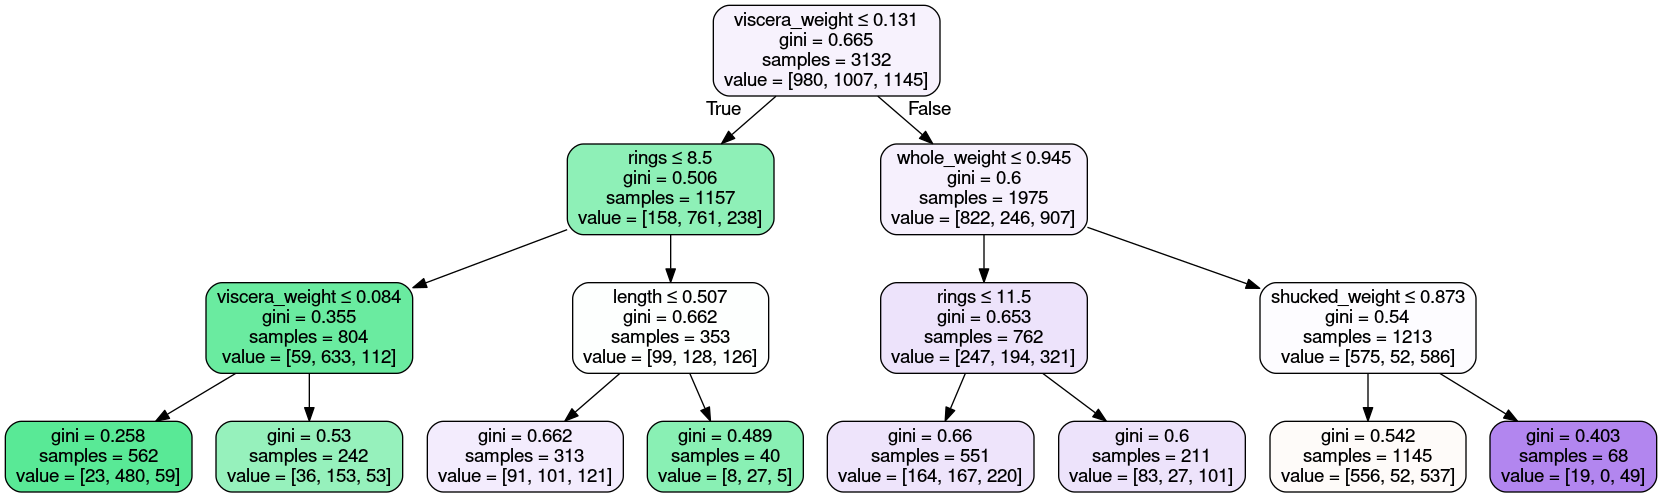

In [43]:
# Visualize classifier of Question 9
clf_tree = ans_9a
visualize_decision_tree(clf_tree, feature_names=X.columns)

In [44]:
importances = pd.DataFrame(index=X.columns, data={'importance': clf_tree.feature_importances_})
importances.sort_values(by='importance', ascending=False).T

,viscera_weight,rings,whole_weight,length,shucked_weight,diameter,height,shell_weight
importance,0.728409,0.165141,0.07486,0.016017,0.015573,0.0,0.0,0.0


## Splitting Strategies

The decision tree classes have an optional hyperparameter `criterion` that has one of two values, **`gini`** and **`entropy`**. These refer to the quantitative measure that is used to compare putative splittings of the data.

<a href="https://en.wikipedia.org/wiki/Entropy_(information_theory)">**Entropy**</a>: *Information entropy* is the average rate at which information is produced by a stochastic source of data.

The measure of information entropy associated with each possible data value is the negative logarithm of the probability mass function for the value:

$$S = - \sum_{i = 1}  p_i \log{ p_i} $$

-----

[**Gini Impurity**](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity): Used by the CART (classification and regression tree) algorithm for classification trees, *Gini impurity* is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it were randomly labelled according to the distribution of labels in the subset. The Gini impurity can be computed by summing the probability ${\displaystyle p_{i}}$ of an item with label ${\displaystyle i}$ being chosen multiplied by the probability $\displaystyle \sum _{k\neq i}p_{k}=1-p_{i}$  of a mistake in categorizing that item. It reaches its minimum (zero) when all cases in the node fall into a single target category.

To compute Gini impurity for a set of items with $\displaystyle J$, classes, suppose $\displaystyle i\in \{1,2,...,J\}$ and let $\displaystyle p_{i} $ be the fraction of items labeled with class $\displaystyle i$ in the set.

$${\displaystyle \operatorname {I} _{G}(p)=\sum _{i=1}^{J}p_{i}\sum _{k\neq i}p_{k}=\sum _{i=1}^{J}p_{i}(1-p_{i})=\sum _{i=1}^{J}(p_{i}-{p_{i}}^{2})=\sum _{i=1}^{J}p_{i}-\sum _{i=1}^{J}{p_{i}}^{2}=1-\sum _{i=1}^{J}{p_{i}}^{2}}$$.


<a id="q-tuning"></a>
[Return to top](#questions)

### Question 10: Tuning Classification Hyperparameters

You now want to see if you can improve the performance of the preceding decision tree classifier. To do this, you can tune some hyperparameters as we did before using Scikit-Learn's `GridSearchCV` class.

+ As a base estimator to clone while doing the grid-search, use a `DecisionTreeClassifier` instantiated with `random_state=24`.
+ You will use the following parameter grid:
  ```python
  params = {'criterion': ['gini', 'entropy'],
            'max_depth': [i for i in range(2, 9)],
            'min_samples_split': [2, 3, 4, 5]}
  ```
+ When instantiating the `GridSearchCV`, use `cv=5` cross-validation folds.
+ Assign the `GridSearchCV` object created to the identifier `ans_10`.
+ Use the `fit` method to carry out the grid search training with `X_train` and `y_train`.

In [51]:
### GRADED
### QUESTION 10
### Execute a grid search to determine an optimal classifier as described above.
### Assign the result to ans_10.
### YOUR SOLUTION HERE:
a = DecisionTreeClassifier(random_state=24)

params = {'criterion': ['gini', 'entropy'],
          'max_depth': [i for i in range(2, 9)],
          'min_samples_split': [2, 3, 4, 5]}


b = GridSearchCV(a, param_grid=params, cv=5)
ans_10 = b.fit(X_train, y_train)
print(b)
### Verification:
#print('Grid search optimal parameters:\n{}'.format(ans_10.best_params_))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=24,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8],
                  

In [46]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


Here's a quick visualization of the decision tree determined by the grid search in Question 10.

In [47]:
# Bind the model object obtained to a mode memorable identifier.
clf_tree = ans_10.best_estimator_
visualize_decision_tree(clf_tree, feature_names=X.columns)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

<a id="q-reporting"></a>
[Return to top](#questions)

### Question 11: Getting a Classification Report

Finally, Scikit-Learn provides a utility [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) in the class `sklearn.metrics`.
+ Use the classifier `clf_tree` obtained from Question 10 to predict target values from the testing data `X_test`. Assign the resulting array to `ans_11a`.
+ Use the function `classification_report`, the predicted target values in `ans_11a`, the expected target values in `y_test` to produce a classification report. You may wish to consult [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).
+ The output of `classification_report` is a string. Assign this string to the identifier `ans_11b`.

In [ ]:
### GRADING
### QUESTION 11
### Save the output from applying the predict method of clf_tree
###     to the testing feature matrix as ans_11a.
### Save the output string from classification_report as ans_11b.
### YOUR SOLUTION HERE:
ans_11a = ...
ans_11b = ...
### Verification:
print('Counts of categories predicted:\n{}\n'.format(pd.Series(ans_11a).value_counts()))
print('Classification report:\n{}'.format(ans_11b))

In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###
